In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

from sarix import sarix
import numpy as np
import pandas as pd
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
import covidcast
from datetime import date

In [2]:
def load_data(as_of = None, end_day = "2021-07-01"):
    """
    Load data for MA cases and hosps from covidcast
    Parameters
    ----------
    as_of: string of date in YYYY-MM-DD format. 
        Default to None.
    end_day: string of date in YYYY-MM-DD format. 
        Default to "2021-07-01"
    Returns
    -------
    df: data frame
        It has columns location, date, inc_hosp, population and rate. 
        It is sorted by location and date columns in ascending order.
    """
    # load hospitalizations
    hosp_df = covidcast.signal(data_source="hhs",
                               signal="confirmed_admissions_covid_1d",
                               start_day=date.fromisoformat("2020-10-01"),
                               end_day=date.fromisoformat(end_day),
                               geo_type="state",
                               geo_values="ma",
                               as_of=as_of)
    hosp_df = hosp_df[["geo_value", "time_value", "value"]]
    hosp_df.columns = ["location", "date", "hosp"]
    
    # load cases
    case_df = covidcast.signal(data_source="jhu-csse",
                          signal="confirmed_incidence_num",
                          start_day=date.fromisoformat("2020-10-01"),
                          end_day=date.fromisoformat(end_day),
                          geo_type="state",
                          geo_values="ma",
                          as_of=None)
    case_df = case_df[["geo_value", "time_value", "value"]]
    case_df.columns = ["location", "date", "case"]
    
    # merge
    df = case_df.merge(hosp_df, on=["location", "date"], how = "left")

    return df

df = load_data(end_day="2021-06-01")
df

,location,date,case,hosp
0,ma,2020-10-01,754.0,42.0
1,ma,2020-10-02,761.0,43.0
2,ma,2020-10-03,672.0,33.0
3,ma,2020-10-04,644.0,44.0
4,ma,2020-10-05,515.0,40.0
...,...,...,...,...
239,ma,2021-05-28,287.0,33.0
240,ma,2021-05-29,224.0,17.0
241,ma,2021-05-30,162.0,26.0
242,ma,2021-05-31,0.0,21.0


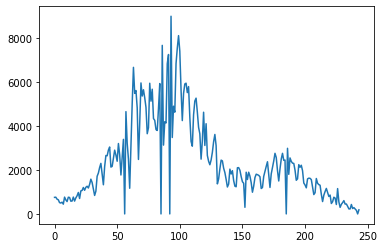

In [3]:
plt.plot(df.case)

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


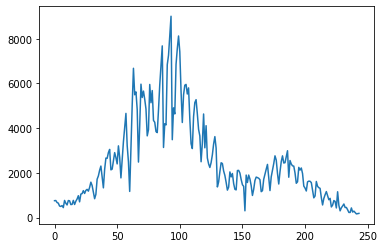

In [4]:
# quick fix to zero values; mean of adjacent
df['case_fixed'] = df.case
zero_inds = np.where(df.case == 0)
df['case_fixed'].iloc[zero_inds] = 0.5 * (df['case_fixed'].iloc[zero_inds[0] - 1].values + df['case_fixed'].iloc[zero_inds[0] + 1].values)
plt.plot(df.case_fixed)

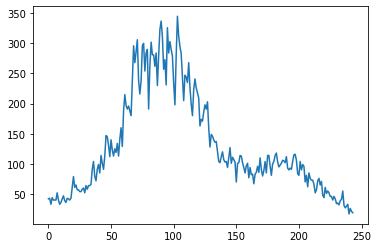

In [5]:
plt.plot(df.hosp)

In [6]:
# quick reload for debug
# from importlib import reload
# sarix = reload(sarix)

In [7]:
sarix_fit = sarix.SARIX(
    xy = df[["case_fixed", "hosp"]].values,
    p = 2,
    P = 1,
    season_period = 7,
    transform = "quarter",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

# stl_fit.plot()

sample: 100%|██████████| 2000/2000 [00:16<00:00, 122.75it/s, 511 steps of size 1.22e-02. acc. prob=0.94] 



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
betas_update_var[0]      0.40      0.02      0.40      0.37      0.43    925.53      1.00
betas_update_var[1]      0.11      0.00      0.11      0.11      0.12    767.36      1.00
           theta[0]      0.47      0.07      0.48      0.38      0.60    767.64      1.00
           theta[1]      0.25      0.06      0.25      0.15      0.35    753.66      1.00
           theta[2]      0.60      0.06      0.60      0.51      0.69    990.22      1.00
           theta[3]     -0.05      0.07     -0.05     -0.17      0.06   1036.03      1.00
           theta[4]     -0.27      0.06     -0.27     -0.38     -0.18    821.99      1.00
           theta[5]      0.02      0.02      0.02     -0.01      0.05    850.23      1.00
           theta[6]      0.06      0.02      0.06      0.03      0.09    832.00      1.00
           theta[7]     -0.00      0.02     -0.00     -0.04      0.03    764.71      1.00
         

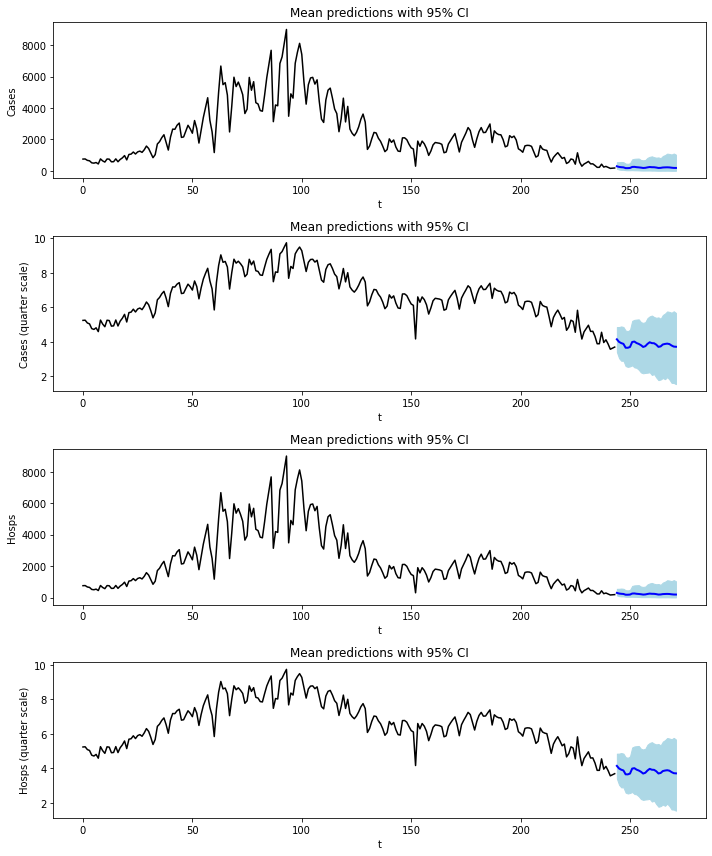

In [8]:
import numpy as onp
save_path = None
t = onp.arange(sarix_fit.xy.shape[0])
t_pred = sarix_fit.xy.shape[0] + onp.arange(sarix_fit.forecast_horizon)

percentile_levels = [2.5, 97.5]
median_prediction = onp.median(sarix_fit.samples['xy_future'], axis=0)
percentiles = onp.percentile(sarix_fit.samples['xy_future'], percentile_levels, axis=0)
median_prediction_orig = onp.median(sarix_fit.predictions_orig, axis=0)
percentiles_orig = onp.percentile(sarix_fit.predictions_orig, percentile_levels, axis=0)

fig, ax = plt.subplots(4, 1, figsize=(10,3 * 4))

var_names = ['Cases', 'Hosps']
for (i, var_name) in enumerate(var_names):
    ax[0 + i*2].fill_between(t_pred, percentiles_orig[0, :, 0], percentiles_orig[1, :, 0], color='lightblue')
    ax[0 + i*2].plot(t_pred, median_prediction_orig[:, 0], 'blue', ls='solid', lw=2.0)
    ax[0 + i*2].plot(t, sarix_fit.xy_orig[:, 0], 'black', ls='solid')
    ax[0 + i*2].set(xlabel="t", ylabel=var_name, title="Mean predictions with 95% CI")

    ax[1 + i*2].fill_between(t_pred, percentiles[0, :, 0], percentiles[1, :, 0], color='lightblue')
    ax[1 + i*2].plot(t_pred, median_prediction[:, 0], 'blue', ls='solid', lw=2.0)
    ax[1 + i*2].plot(t, sarix_fit.xy[:, 0], 'black', ls='solid')
    ax[1 + i*2].set(xlabel="t", ylabel=var_name + " (" + sarix_fit.transform + " scale)", title="Mean predictions with 95% CI")


plt.tight_layout()

if save_path is not None:
    plt.savefig(save_path)

plt.show()
